In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import json
import operator
import math
from adjustText import adjust_text
from matplotlib import patches
import sys
sys.path.append('..')
from helpers.funcs import *

In [2]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
TWEET_DIR = config['TWEET_DIR']

In [3]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))
keywords = json.load(open(INPUT_DIR + "event_keyword_dict.json","r"))
keywords_other = json.load(open(INPUT_DIR + "other_event_keywords.json","r"))

In [4]:
event2idx = {e: i for i, e in enumerate(events)}
idx2event = {i: e for i, e in enumerate(events)}
other2idx = {e: i for i, e in enumerate(keywords_other.keys())}
idx2other = {i: e for i, e in enumerate(keywords_other.keys())}

In [5]:
event_mentions_dem = {e: 0 for e in events + list(keywords_other.keys())}
event_mentions_rep = {e: 0 for e in events + list(keywords_other.keys())}

In [6]:
def split_party(tweets):
    partisan = tweets[~tweets['dem_follows'].isnull() & ~tweets['rep_follows'].isnull() & (tweets['dem_follows'] != tweets['rep_follows'])]
    return (partisan['dem_follows'] > partisan['rep_follows']).sum(), (partisan['dem_follows'] < partisan['rep_follows']).sum()

In [7]:
# count mentions 
for i, e in enumerate(events):
    print(e)
    tweets = pd.read_csv(TWEET_DIR +e+'/'+e+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'remove', 'isRT', 'dem_follows', 'rep_follows'])
    tweets = filter_retweets(tweets)
    # consider only events that happened before a particular event
    for e2 in events[:i]: 
        contains = tweets[tweets['text'].str.contains(keywords[e2], case=False)]
        dem, rep = split_party(contains)
        event_mentions_dem[e2] += dem
        event_mentions_rep[e2] += rep
    for k, v in keywords_other.items():
        contains = tweets[tweets['text'].str.contains(v, case=False)]
        dem, rep = split_party(contains)
        event_mentions_dem[k] += dem
        event_mentions_rep[k] += rep

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [9]:
odds = {}
total = {}
proportion = {}
rep_sum = float(sum(event_mentions_rep.values()))
dem_sum = float(sum(event_mentions_dem.values()))
for k, v in event_mentions_dem.items():
    # we ignore San Francisco, since it's a major city, so its signal is less reliable
    # but if we include it, it lies right by the "neutral" line
    if k == 'san_francisco':  
        continue
        
    # format event name
    label = k.replace('ft', 'Fort')
    label = label.replace('va_', 'VA_')
    label = label.split('_')
    new_label = []
    for l in label:
        new_label.append(l[0].upper() + l[1:])
    new_label = ' '.join(new_label)
    
    # if there are less than 100 mentions total of a particular event, ignore
    if v < 100 and event_mentions_rep[k] < 100:   
        continue
    
    # calculate log odds
    odds[new_label] =  np.log((event_mentions_rep[k] / (rep_sum - event_mentions_rep[k])) / (v / (dem_sum - v)))
    
    # calculate proportion of mentions in Republican tweets
    total[new_label] = v + event_mentions_rep[k]
    proportion[new_label] = event_mentions_rep[k] / total[new_label]
    
sorted(odds.items(), key=operator.itemgetter(1))

[('Pittsburgh', -1.2647234732965664),
 ('Sandy Hook', -1.1378022638659804),
 ('Roseburg', -0.8934184102574322),
 ('Sutherland Springs', -0.7505405964288583),
 ('Parkland', -0.7449575465107966),
 ('Columbine', -0.6226253959090698),
 ('VA Tech', -0.5892366653465149),
 ('Charleston', -0.527977803302678),
 ('Vegas', -0.3439351417793536),
 ('Colorado Springs', -0.2423757279389018),
 ('Orlando', -0.14776636500558282),
 ('Fort Lauderdale', 0.0038182789299053103),
 ('Boston', 0.33941274852875447),
 ('Dallas', 0.5708477096849793),
 ('San Bernardino', 0.6208778699793552),
 ('Fresno', 0.7944584427168884),
 ('9/11', 1.3156660746011624),
 ('Fort Hood', 1.4785263051156592),
 ('Chattanooga', 1.8793301142552707)]

In [10]:
white = ['Nashville', 'Pittsburgh', 'Sandy Hook', 'VA Tech', 'Columbine', 'Parkland', 'Sutherland Springs', 'Vegas', 'Charleston', 'Colorado Springs']
POC = ['Roseburg', 'Orlando', 'San Francisco', 'Fort Hood', 'San Bernardino', 'Fort Lauderdale', 'Boston', 'Dallas', 'Fresno', '9/11', 'Chattanooga']
school = ['Sandy Hook', 'VA Tech', 'Roseburg', 'Columbine', 'Parkland']
worship = ['Pittsburgh', 'Sutherland Springs', 'Charleston']


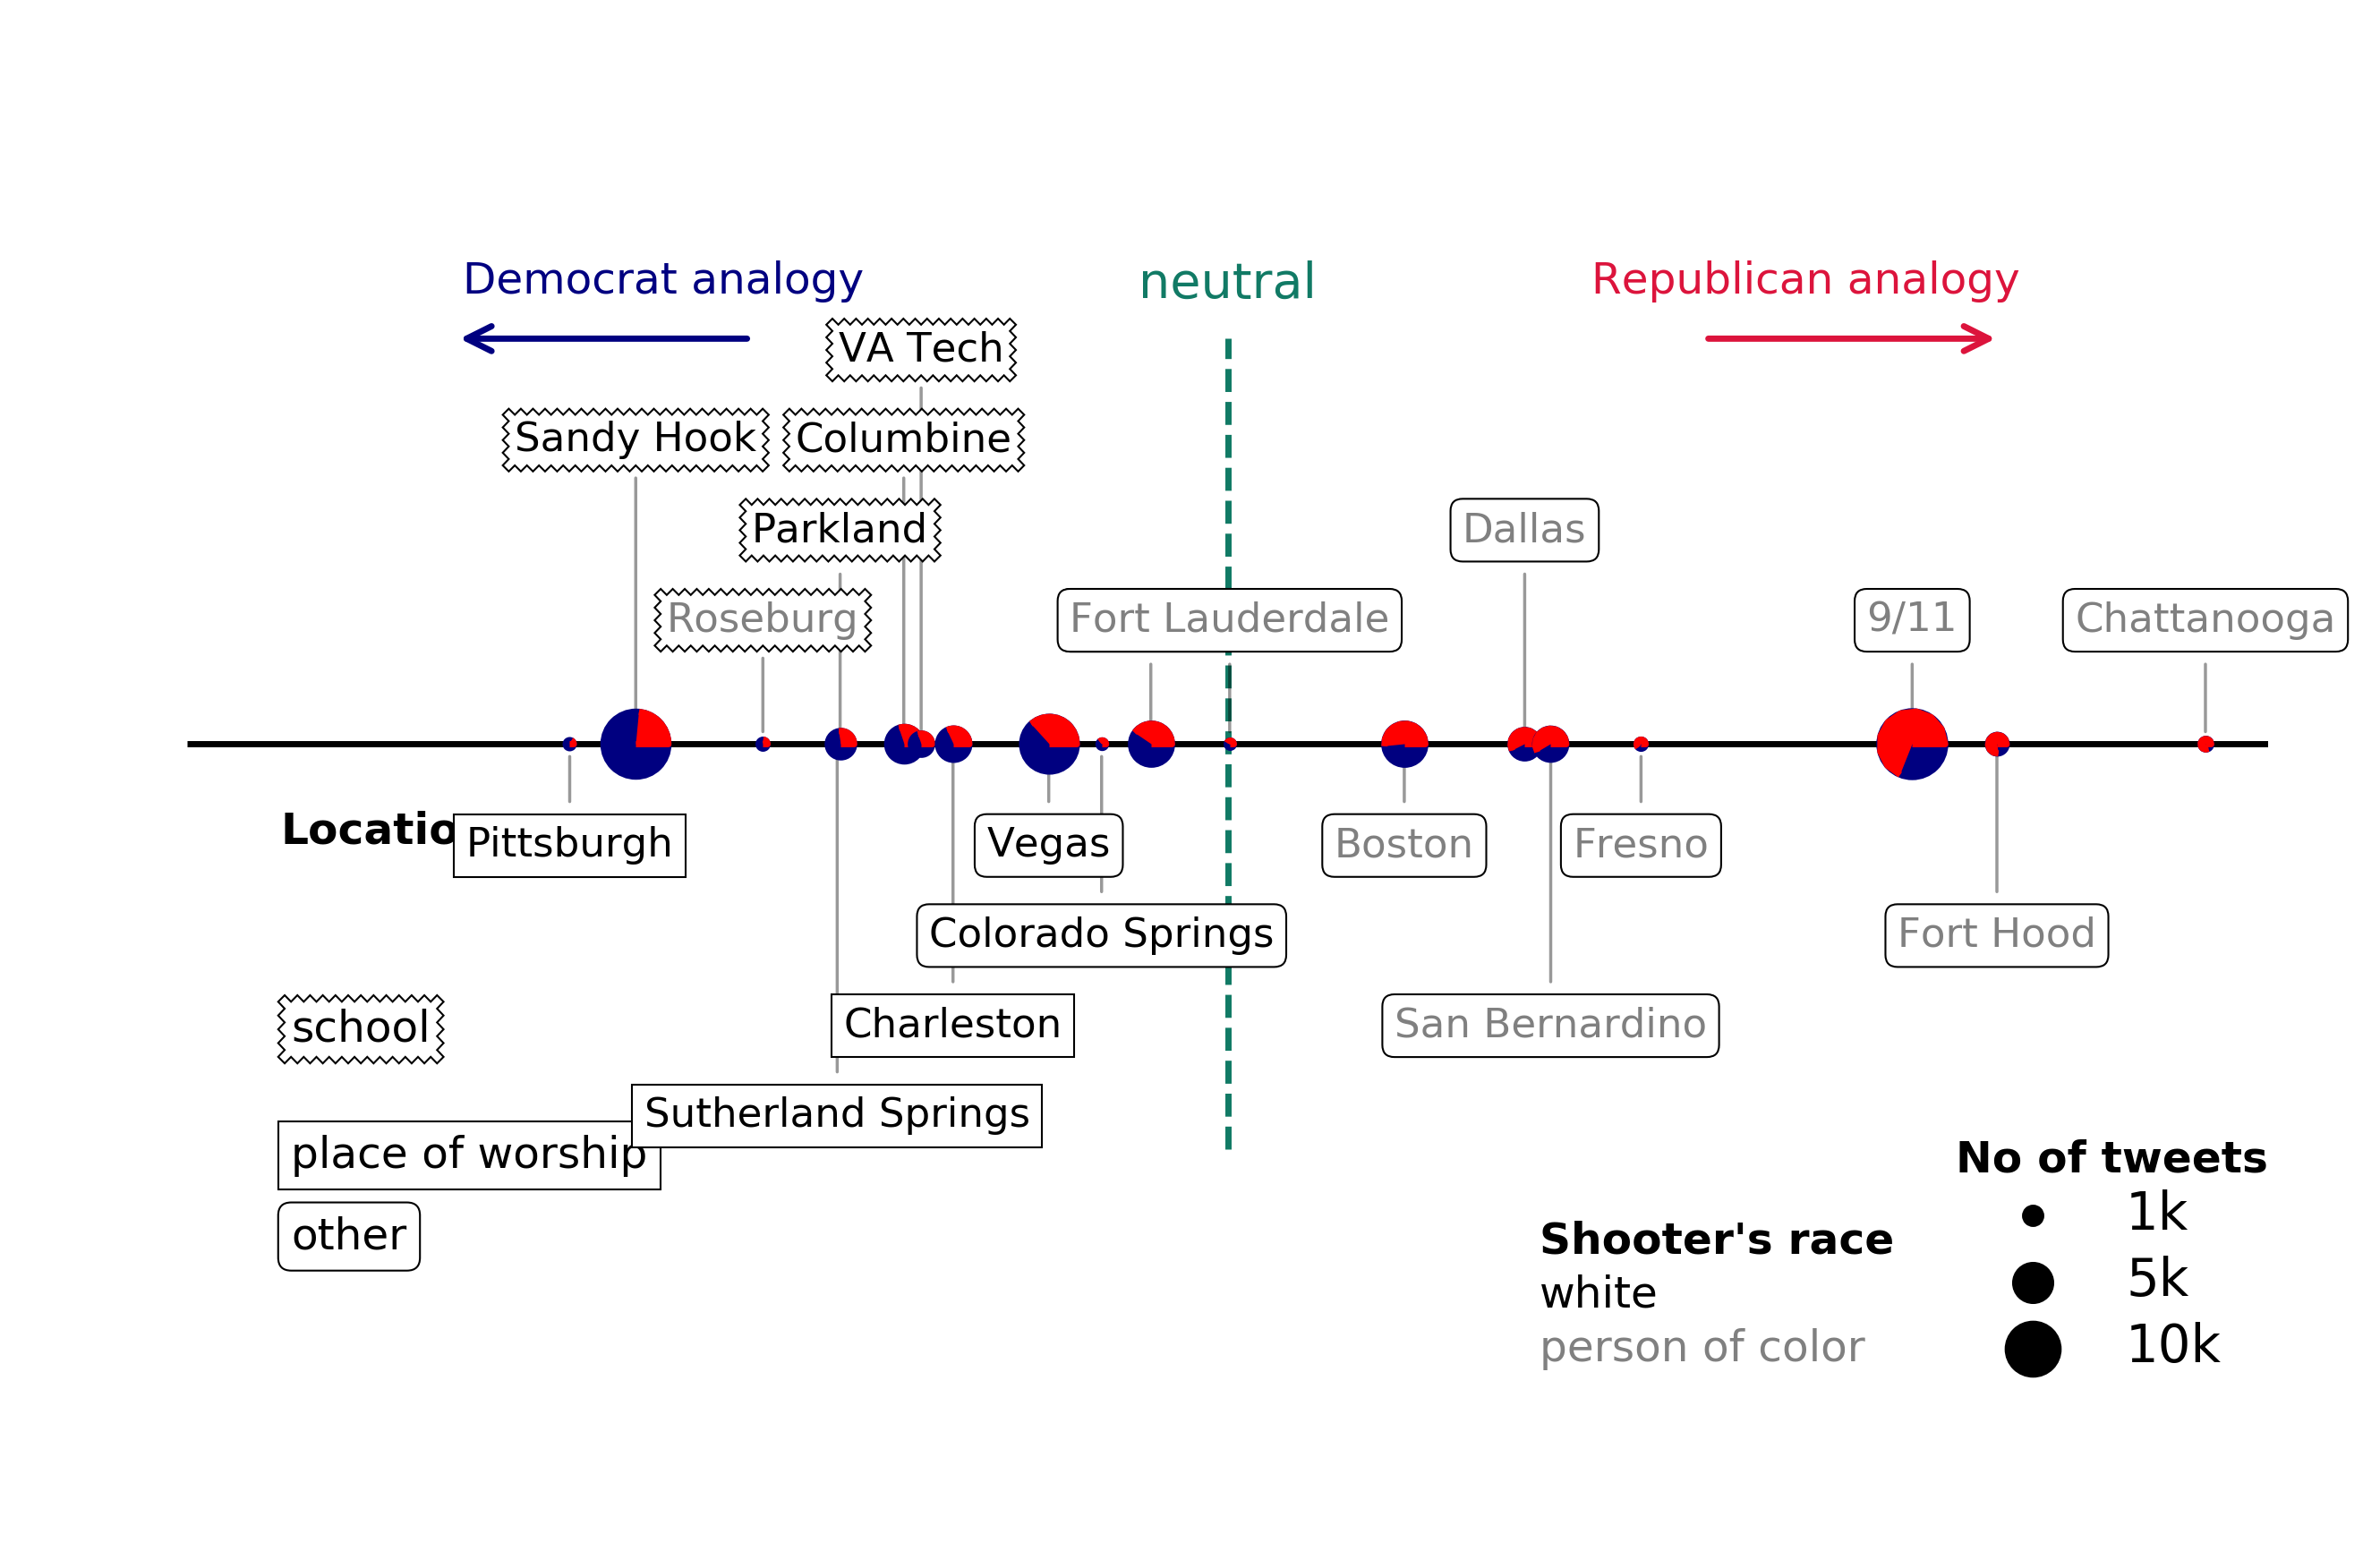

In [13]:
# set up the figure
fig = plt.figure(dpi=500)
ax = fig.add_subplot(111)
xmin = -2
xmax = 2
ymin = 0
ymax = 3
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin, ymax)
y = (ymax-ymin)/2
scale = y/10
size_div = 150

texts = []
ax.hlines(y, xmin, xmax, lw=1)
ax.vlines(0, y-.9, y + .9, color='#117A65', linestyles='dashed', lw=1)
ax.text(0, y + .99, 'neutral', horizontalalignment='center', color='#117A65', fontsize=8)

sorted_odds = sorted(odds.items(), key=operator.itemgetter(1))
count = 0
text_positions = {'Nashville':scale+.1, 'Pittsburgh':-scale-.1, 'Sandy Hook':scale+.5, 'VA Tech': scale+.7, 'Parkland':scale+.3, 'Roseburg': scale+.1, 'Columbine':scale+.5, 'Sutherland Springs':-scale-.7, 'Vegas':-scale-.1, 'Orlando':scale+.1, 'Charleston':-scale-.5, 'San Francisco':-scale-.3, 'Dallas':scale+.3, 'Fort Hood':-scale-.3, 'San Bernardino':-scale-.5, 'Boston':-scale-.1, 'Fort Lauderdale':scale+.1, 'Fresno':-scale-.1, 'Colorado Springs':-scale-.3, '9/11':scale+.1, 'Chattanooga':scale+.1}
for k, odd_val in sorted_odds:
    x_c = [0] + np.cos(np.linspace(0, 2*math.pi*proportion[k], 10)).tolist()
    y_c = [0] + np.sin(np.linspace(0, 2*math.pi*proportion[k], 10)).tolist()

    xy = list(zip(x_c, y_c))
    s_c = max(max(x_c), max(y_c))
    style = 'sawtooth' if k in school else 'round'
    style = 'square' if k in worship else style
    
    ax.annotate(k, (odd_val, y), xytext=(odd_val,  y+text_positions[k]), bbox=dict(boxstyle=style, fc="w", lw=.3), fontsize=6.5, color='black' if k in white else 'gray', ha='center', arrowprops=dict(arrowstyle="-", color='black', lw=0.5, alpha=0.4), zorder=10*(y-np.abs(text_positions[k])))
    
    ax.scatter(odd_val,y, s=(total[k]/size_div), c = 'navy', zorder=1000)
    ax.scatter(odd_val,y, s=(total[k]/size_div), marker=(xy, 0), c = 'r', zorder=1000)
    
    count +=1

#patch = patches.Rectangle((xmin, y-height/2.), xmax-xmin, height, linewidth=0, fill=False)
#ax.add_patch(patch)
#adjust_text(texts, x=[x for _, x in sorted_odds], y=[y] * len(texts), add_objects=[patch], expand_objects=(1,3), force_objects=(1,2), expand_text=(6, 2), force_text=(2,2), arrowprops=dict(arrowstyle="-", color='black', lw=0.2, alpha=0.4), autoalign=False, only_move={'text':'y', 'objects':'y', 'points':'y'})
# add numbers
ax.text(-.7, y+1, 'Democrat analogy', horizontalalignment='right', fontsize=7, color='navy')
ax.text(.7, y+1, 'Republican analogy', horizontalalignment='left', fontsize=7, color='crimson')
ax.text(-1.82, 1.28, 'Location', horizontalalignment='left', fontsize=7, weight='heavy')
ax.text(-1.8, .84, 'school',horizontalalignment='left', bbox=dict(boxstyle='sawtooth', fc="w", lw=.3), fontsize=7)
ax.text(-1.8, .56, 'place of worship',horizontalalignment='left', bbox=dict(boxstyle='square', fc="w", lw=.3), fontsize=7)
ax.text(-1.8, .38, 'other',horizontalalignment='left', bbox=dict(boxstyle='round', fc="w", lw=.3), fontsize=7)
ax.text(.6, .37, "Shooter's race", horizontalalignment='left', fontsize=7, weight='heavy')
ax.text(.6, .25, "white", horizontalalignment='left', fontsize=7)
ax.text(.6, .13, "person of color", horizontalalignment='left', fontsize=7, color='gray')

plt.annotate("", xy=(-1.5, y+.9), xycoords='data', xytext=(-.9, y+.9), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='navy', lw=1),)

plt.annotate("", xy=(1.5, y+.9), xycoords='data', xytext=(.9, y+.9), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='crimson', lw=1),)



# make legend with dummy points
for a in [1000, 5000, 10000]:
    plt.scatter([], [], c='black', s=a/size_div,
                label=str(int(a/1000))+'k')
plt.legend(scatterpoints=1, frameon=False, fontsize='small',
           labelspacing=.3, loc='lower right', title='')
ax.text(1.4, .55, 'No of tweets', horizontalalignment='left', fontsize=7, weight='heavy')

plt.axis('off')

plt.show()